The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==1.0.0-alpha1.post0


# Residual Networks (ResNet) and ResNeXt
:label:`sec_resnet`

As we design increasingly deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network.
Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different.
To make some progress we need a bit of mathematics.


## Function Classes

Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach.
That is, for all $f \in \mathcal{F}$ there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset.
Let's assume that $f^*$ is the "truth" function that we really would like to find.
If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky.
Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$.
For instance,
given a dataset with features $\mathbf{X}$
and labels $\mathbf{y}$,
we might try finding it by solving the following optimization problem:

$$f^*_\mathcal{F} \stackrel{\mathrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

We know that regularization :cite:`tikhonov1977solutions,morozov2012methods` may control complexity of $\mathcal{F}$
and achieve consistency, so a larger size of training data
generally leads to better $f^*_\mathcal{F}$.
It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is "better" than $f^*_{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse.
As illustrated by :numref:`fig_functionclasses`,
for non-nested function classes, a larger function class does not always move closer to the "truth" function $f^*$. For instance,
on the left of :numref:`fig_functionclasses`,
though $\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1$, $\mathcal{F}_6$ moves away and there is no guarantee that further increasing the complexity can reduce the distance from $f^*$.
With nested function classes
where $\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$
on the right of :numref:`fig_functionclasses`,
we can avoid the aforementioned issue from the non-nested function classes.


![For non-nested function classes, a larger (indicated by area) function class does not guarantee to get closer to the "truth" function ($f^*$). This does not happen in nested function classes.](http://d2l.ai/_images/functionclasses.svg)
:label:`fig_functionclasses`

Thus,
only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network.
For deep neural networks,
if we can
train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.

This is the question that :cite:`He.Zhang.Ren.ea.2016` considered when working on very deep computer vision models.
At the heart of their proposed *residual network* (*ResNet*) is the idea that every additional layer should
more easily
contain the identity function as one of its elements.
These considerations are rather profound but they led to a surprisingly simple
solution, a *residual block*.
With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to
build deep neural networks. For instance, residual blocks have been added to recurrent networks :cite:`prakash2016neural,kim2017residual`. Likewise, transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017` use them to stack many layers of networks efficiently. It is also used in graph neural networks :cite:`Kipf.Welling.2016` and, as a basic concept, it has been used extensively in computer vision :cite:`Redmon.Farhadi.2018,Ren.He.Girshick.ea.2015`. 
Note that residual networks are predated by highway networks :cite:`srivastava2015highway` that share some of the motivation, albeit without the elegant parametrization around the identity function.


## (**Residual Blocks**)
:label:`subsec_residual-blks`

Let's focus on a local part of a neural network, as depicted in :numref:`fig_residual_block`. Denote the input by $\mathbf{x}$.
We assume that the desired underlying mapping we want to obtain by learning is $f(\mathbf{x})$, to be used as input to the activation function on the top.
On the left,
the portion within the dotted-line box
must directly learn the mapping $f(\mathbf{x})$.
On the right,
the portion within the dotted-line box
needs to
learn the *residual mapping* $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$,
which is how the residual block derives its name.
If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping,
the residual mapping amounts to $g(\mathbf{x}) = 0$ and it is thus easier to learn:
we only need to push the weights and biases
of the
upper weight layer (e.g., fully connected layer and convolutional layer)
within the dotted-line box
to zero.
The right figure illustrates the *residual block* of ResNet,
where the solid line carrying the layer input
$\mathbf{x}$ to the addition operator
is called a *residual connection* (or *shortcut connection*).
With residual blocks, inputs can
forward propagate faster through the residual connections across layers.
In fact,
the residual block
can be thought of as
a special case of the multi-branch Inception block:
it has two branches
one of which is the identity mapping.

![In a regular block (left), the portion within the dotted-line box must directly learn the mapping $f(\mathbf{x})$. In a residual block (right), the portion within the dotted-line box needs to learn the residual mapping $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$, making the identity mapping $f(\mathbf{x}) = \mathbf{x}$ easier to learn.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/residual-block.svg?raw=1)
:label:`fig_residual_block`


ResNet follows VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let's have a look at the code below.


In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l


class Residual(tf.keras.Model):  
    """The Residual block of ResNet."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                            kernel_size=3, strides=strides)
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')
        self.conv3 = None
        if use_1x1conv:
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever `use_1x1conv=False`, and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. :numref:`fig_resnet_block` illustrates this.

![ResNet block with and without $1 \times 1$ convolution, which transforms the input into the desired shape for the addition operation.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/resnet-block.svg?raw=1)
:label:`fig_resnet_block`

Now let's look at [**a situation where the input and output are of the same shape**], where $1 \times 1$ convolution is not needed.


In [ ]:
blk = Residual(3)
X = tf.random.normal((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 6, 6, 3])

We also have the option to [**halve the output height and width while increasing the number of output channels**].
In this case we use $1 \times 1$ convolutions via `use_1x1conv=True`. This comes in handy at the beginning of each ResNet block to reduce the spatial dimensionality via `strides=2`.


In [ ]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

TensorShape([4, 3, 3, 6])

## [**ResNet Model**]

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ max-pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.


In [ ]:
class ResNet(d2l.Classifier):
    def b1(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(64, kernel_size=7, strides=2,
                                   padding='same'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2,
                                      padding='same')])

GoogLeNet uses four modules made up of Inception blocks.
However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels.
The number of channels in the first module is the same as the number of input channels. Since a max-pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.


In [ ]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = tf.keras.models.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module. Lastly, just like GoogLeNet, we add a global average pooling layer, followed by the fully connected layer output.


In [ ]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = tf.keras.models.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add(self.block(*b, first_block=(i==0)))
    self.net.add(tf.keras.models.Sequential([
        tf.keras.layers.GlobalAvgPool2D(),
        tf.keras.layers.Dense(units=num_classes)]))

There are 4 convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18.
By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet's structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet. :numref:`fig_resnet18` depicts the full ResNet-18.

![The ResNet-18 architecture.](https://github.com/d2l-ai/d2l-tensorflow-colab/blob/master/img/resnet18-90.svg?raw=1)
:label:`fig_resnet18`

Before training ResNet, let's [**observe how the input shape changes across different modules in ResNet**]. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.


In [ ]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

In [ ]:
ResNet18().layer_summary((1, 96, 96, 1))

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 128)
Sequential output shape:	 (1, 6, 6, 256)
Sequential output shape:	 (1, 3, 3, 512)
Sequential output shape:	 (1, 10)


## [**Training**]

We train ResNet on the Fashion-MNIST dataset, just like before. ResNet is quite a powerful and flexible architecture. The plot capturing training and validation loss illustrates a significant gap between both graphs, with the training loss being significantly lower. For a network of this flexibility, more training data would offer significant benefit in closing the gap and improving accuracy.


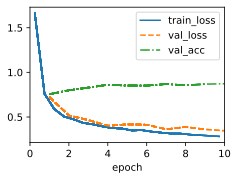

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
with d2l.try_gpu():
    model = ResNet18(lr=0.01)
    trainer.fit(model, data)

Avaliação:
São poucas as diferenças de desempenho com as alterações propostas no modelo. Uma perda um pouco menor nas primeiras épocas (em relação ao modelo original).